In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import langid
import matplotlib.pyplot as plt
import seaborn as sns
import swifter

In [2]:
all_tweets=pd.read_csv("2016_Senti.csv")

In [3]:
all_tweets.head()

,Unnamed: 0,tweet_text,Candidate
0,0,Parental #BasementDwellers: @HillaryClinton C...,Clinton
1,1,"The entertainment world is way ahead of you, @...",Clinton
2,2,@CNN @RobynCurnowCNN I note that your Co still...,Trump
3,3,@docmurdock @realDonaldTrump @mitchellvii At W...,Clinton
4,4,@realDonaldTrump is a giant orange cunt,Trump


In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
def clean_text(text):
    if isinstance(text, str):  # Check if the input is a string
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
        text = re.sub(r'#', '', text)  # Remove hashtags
        text = re.sub(r'RT[\s]+', '', text)  # Remove retweets
        text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Remove special characters

        # Tokenization and removing stop words
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

        return ' '.join(words)
    else:
        return ''  # Return an empty string for non-string inputs

In [6]:
all_tweets['cleaned_text'] = all_tweets['tweet_text'].astype(str).swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/2000000 [00:00<?, ?it/s]

In [7]:
def detect_language(text):
    lang, _ = langid.classify(text)
    return lang

In [8]:
all_tweets['language'] = all_tweets['cleaned_text'].astype(str).swifter.apply(detect_language)
df = all_tweets.copy()

Pandas Apply:   0%|          | 0/2000000 [00:00<?, ?it/s]

In [9]:
all_tweets = all_tweets[all_tweets['language'] == 'en']

In [10]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [11]:
all_tweets['sentiment'] = all_tweets['cleaned_text'].astype(str).swifter.apply(get_sentiment)

Pandas Apply:   0%|          | 0/1597520 [00:00<?, ?it/s]

In [12]:
all_tweets

,Unnamed: 0,tweet_text,Candidate,cleaned_text,language,sentiment
0,0,Parental #BasementDwellers: @HillaryClinton C...,Clinton,parental basementdwellers criticizes voters bo...,en,-0.4
1,1,"The entertainment world is way ahead of you, @...",Clinton,entertainment world way ahead,en,0.0
2,2,@CNN @RobynCurnowCNN I note that your Co still...,Trump,note co still brings people living another pla...,en,-0.3
3,3,@docmurdock @realDonaldTrump @mitchellvii At W...,Clinton,point stop looking way b,en,0.0
4,4,@realDonaldTrump is a giant orange cunt,Trump,giant orange cunt,en,0.0
...,...,...,...,...,...,...
1999995,1999995,"@realDonaldTrump @POTUS @Nordstrom You utter, ...",Trump,utter utter cock womble,en,0.0
1999996,1999996,@trumpology @HillaryClinton @dylanversity Hust...,Clinton,hust go away hitlery,en,0.0
1999997,1999997,@realDonaldTrump @mike_pence congratulations B...,Trump,pence congratulations boss earned earned,en,0.0
1999998,1999998,@realDonaldTrump https://t.co/MHWrYhHfHf,Trump,,en,0.0


In [13]:
def get_topics(texts, num_topics=4):
    vectorizer = CountVectorizer(max_df=0.85, max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(texts)
    
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    
    return lda

In [14]:
lda_model = get_topics(all_tweets['cleaned_text'])

In [15]:
texts = all_tweets['cleaned_text']

# Create and fit the vectorizer
vectorizer = CountVectorizer(max_df=0.85, max_features=1000, stop_words='english')
X = vectorizer.fit_transform(texts)

In [16]:
topic_distributions = lda_model.transform(X)

In [17]:
all_tweets['dominant_topic'] = topic_distributions.argmax(axis=1)

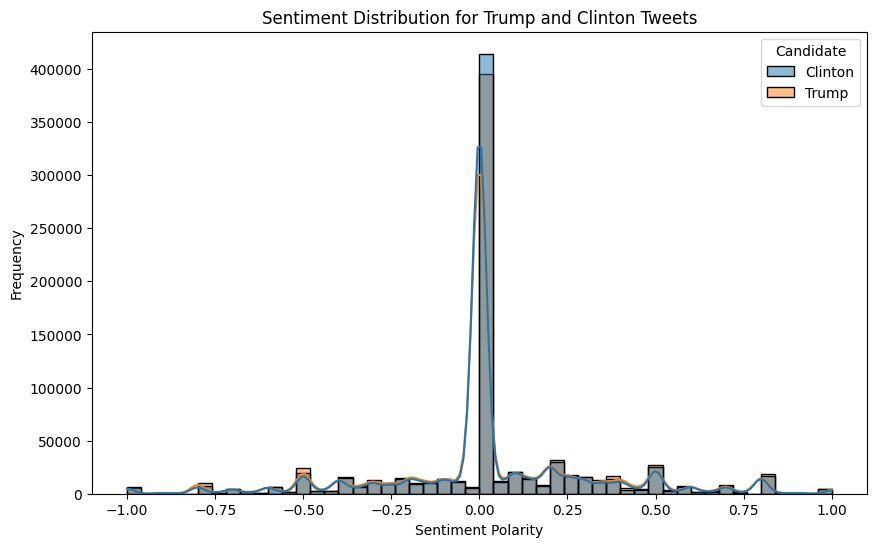

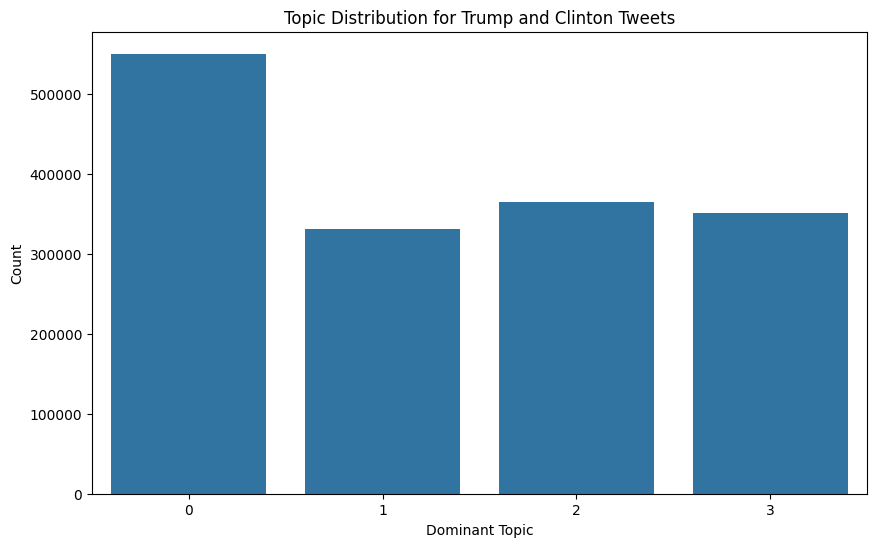

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(all_tweets, x='sentiment',hue='Candidate',bins=50, kde=True)
plt.title('Sentiment Distribution for Trump and Clinton Tweets')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Visualize topic distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='dominant_topic', data=all_tweets)
plt.title('Topic Distribution for Trump and Clinton Tweets')
plt.xlabel('Dominant Topic')
plt.ylabel('Count')
plt.show()


In [21]:
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda_model.components_):
    print(f"Topic {i}: {', '.join([feature_names[index] for index in topic.argsort()[-10:]])}")

Topic 0: mr, media, fake, real, donald, news, pence, president, like, trump
Topic 1: white, maga, election, yes, need, trump, good, clinton, people, hillary
Topic 2: support, god, americans, know, country, america, time, vote, trump, amp
Topic 3: lying, love, oh, thing, got, know, really, want, right, think


In [22]:
keywords = ['economy', 'finance', 'budget']
pattern = '|'.join(keywords)
economy_tweets = all_tweets[all_tweets['cleaned_text'].str.contains(pattern, case=False, na=False)]

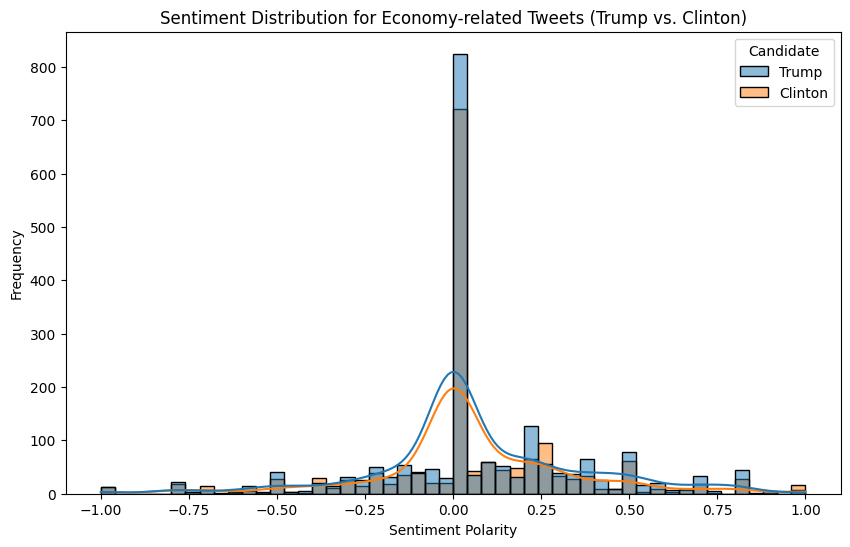

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(economy_tweets, x='sentiment',hue='Candidate', bins=50, kde=True)
plt.title('Sentiment Distribution for Economy-related Tweets (Trump vs. Clinton)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [25]:
economy_tweets

,Unnamed: 0,tweet_text,Candidate,cleaned_text,language,sentiment,dominant_topic
1054,1054,There is your budget @realDonaldTrump \nEasy c...,Trump,budget easy calculation,en,0.433333,0
1699,1699,@jordandeanteam @Scaramucci @realDonaldTrump a...,Trump,thriving economy benefits poorest,en,0.000000,2
2167,2167,@KeHay @PowerfulHER @rtraister &amp; the Husba...,Clinton,amp husband democrat candidate would take econ...,en,0.000000,1
2553,2553,.@HillaryClinton Our national debt is $19What'...,Clinton,national debt fiscal plan askforaplan intend s...,en,0.000000,2
2680,2680,@FoxNews @HillaryClinton by having the Saudis ...,Clinton,saudis finance campaign,en,0.000000,2
...,...,...,...,...,...,...,...
1998069,1998069,@realDonaldTrump \nTrump needs to stay out of ...,Trump,trump needs stay gutter talk american people c...,en,0.000000,2
1998155,1998155,@realDonaldTrump take on the legal profession:...,Trump,take legal profession top economy modernize co...,en,0.350000,2
1998367,1998367,Why @HillaryClinton is the best choice to lead...,Clinton,best choice lead us economy via via,en,1.000000,2
1998912,1998912,if @HillaryClinton had a good idea to make the...,Clinton,good idea make economy better tell buddy trumpwon,en,0.600000,0


In [26]:
all_tweets.to_csv("2016_US_Analysis")

In [27]:
economy_tweets.to_csv('2016_US_Economy.csv')

In [28]:
keywords = ['terrorism', 'terrorists', 'terror','bomb']
pattern = '|'.join(keywords)
terror_tweets = all_tweets[all_tweets['cleaned_text'].str.contains(pattern, case=False, na=False)]

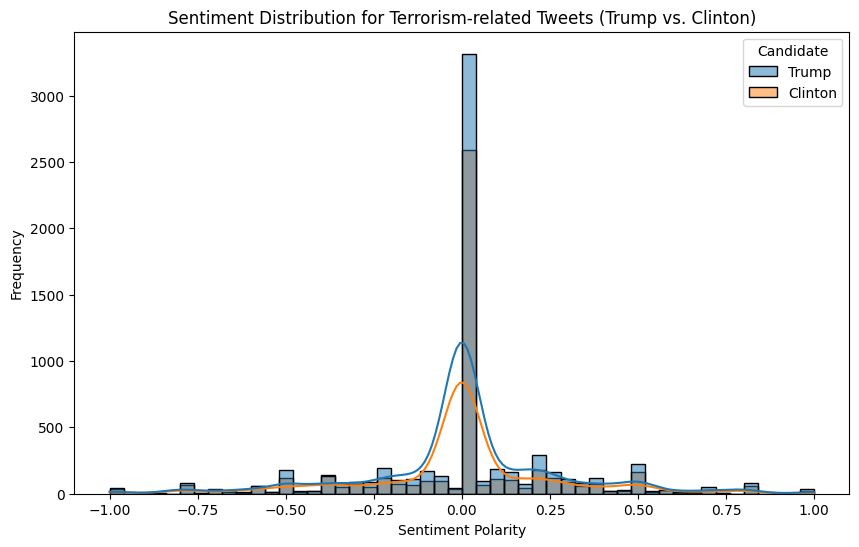

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(terror_tweets, x='sentiment',hue='Candidate', bins=50, kde=True)
plt.title('Sentiment Distribution for Terrorism-related Tweets (Trump vs. Clinton)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [31]:
terror_tweets

,Unnamed: 0,tweet_text,Candidate,cleaned_text,language,sentiment,dominant_topic
147,147,"@realDonaldTrump No Mr. Trump, you are the #1 ...",Trump,mr trump terror,en,0.00,0
326,326,China supporting terrorist Masood Azhar at UN ...,Trump,china supporting terrorist masood azhar un sho...,en,-0.15,2
495,495,@realDonaldTrump look closely at the real face...,Trump,look closely real face terror attacks america ...,en,0.20,0
731,731,Media hates when @realDonaldTrump calls terror...,Trump,media hates calls terrorist act early time mak...,en,0.10,2
1236,1236,@realDonaldTrump @FoxNews Mark my words. If he...,Trump,mark words gets desperate enough approval rati...,en,-0.30,0
...,...,...,...,...,...,...,...
1999657,1999657,@realDonaldTrump trump is monster of terrorist...,Trump,trump monster terrorists trumpwarnsiranianterr...,en,0.00,3
1999670,1999670,@realDonaldTrump I just want to know how many ...,Trump,want know many terrorists come countries busin...,en,0.50,3
1999732,1999732,"Amusing, @HillaryClinton! 🙄 How many terrorist...",Clinton,amusing many terrorists taken battle field sen...,en,0.55,3
1999764,1999764,@HillaryClinton Lady - you want to risk World ...,Clinton,lady want risk world war russia protect muslim...,en,0.00,0


In [39]:
terror_tweets.to_csv("2016_US_Terror.csv")

In [32]:
keywords = ['health', 'healthcare', 'health care','medical','pharma']
pattern = '|'.join(keywords)
health_tweets = all_tweets[all_tweets['cleaned_text'].str.contains(pattern, case=False, na=False)]

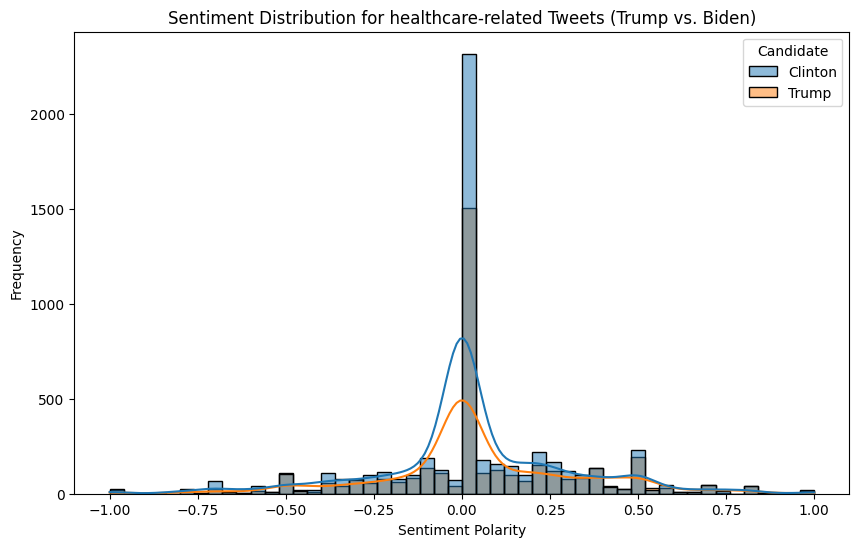

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(health_tweets, x='sentiment',hue='Candidate', bins=50, kde=True)
plt.title('Sentiment Distribution for healthcare-related Tweets (Trump vs. Biden)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [35]:
health_tweets

,Unnamed: 0,tweet_text,Candidate,cleaned_text,language,sentiment,dominant_topic
140,140,@eyetarzan @HillaryClinton @realDonaldTrump sh...,Clinton,also disclosed health report emails,en,0.000000,2
270,270,"My candidate fought for commonsense gun laws, ...",Clinton,candidate fought commonsense gun laws jobs amp...,en,0.000000,2
526,526,".@mtracey my gf is on point.. ""Reagan got shot...",Clinton,gf point reagan got shot amp needed less help ...,en,-0.166667,2
627,627,"@FoxNews @HillaryClinton ""apparently"" to a hos...",Clinton,apparently hospital apparent medical problem g...,en,-0.340000,2
1077,1077,@realDonaldTrump Psychologist will try to make...,Trump,psychologist try make hillary pass debate vote...,en,0.700000,1
...,...,...,...,...,...,...,...
1999153,1999153,@HillaryClinton handles crowd after #debatenig...,Clinton,handles crowd debatenight like boss leaves suv...,en,0.000000,2
1999654,1999654,"So, who's ill, actually? Original or double @H...",Clinton,ill actually original double please answer asa...,en,-0.041667,1
1999685,1999685,@realDonaldTrump good answer on health care. ...,Clinton,good answer health care good answer also tie o...,en,0.700000,1
1999735,1999735,@NickR27 @MikeNicolella @realDonaldTrump 4 the...,Trump,last years republicans refused work healthcare...,en,0.000000,2


In [41]:
health_tweets.to_csv("2016_US_health.csv")

In [36]:
keywords = ['foreign', 'foreign policy', 'china','russia','Korea','mexi']
pattern = '|'.join(keywords)
foreign_tweets=all_tweets[all_tweets['cleaned_text'].str.contains(pattern, case=False, na=False)]

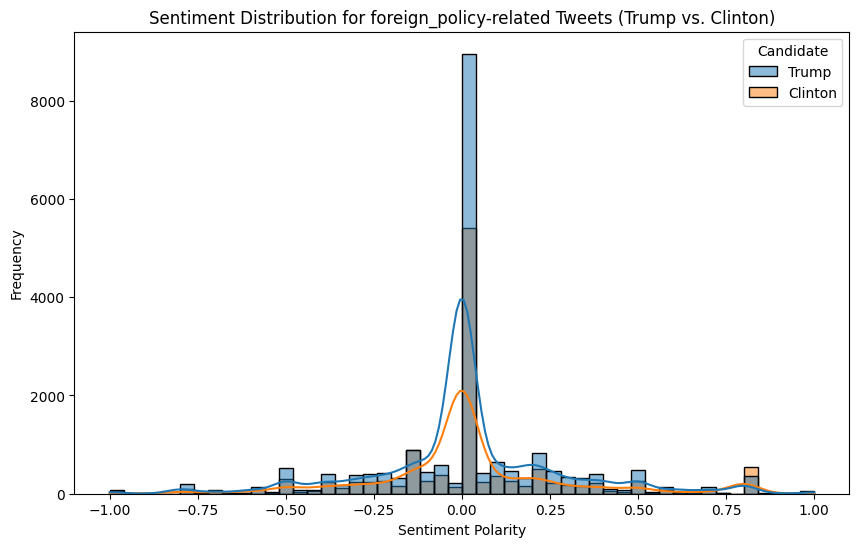

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(foreign_tweets, x='sentiment',hue='Candidate', bins=50, kde=True)
plt.title('Sentiment Distribution for foreign_policy-related Tweets (Trump vs. Clinton)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [38]:
foreign_tweets

,Unnamed: 0,tweet_text,Candidate,cleaned_text,language,sentiment,dominant_topic
35,35,"@realDonaldTrump alright, when is the #gop goi...",Trump,alright gop going let everyone joke say real c...,en,0.200000,0
114,114,@DNCWomen @cnn Are the Russians responsible fo...,Trump,russians responsible pic youtube video maga,en,0.200000,3
149,149,Interesting timing of this tweet by @realDonal...,Trump,interesting timing tweet one day flynn call ru...,en,0.095238,3
184,184,"@realDonaldTrump so, which one would you prefe...",Trump,one would prefer exile russia needs roomie jai...,en,0.166667,0
218,218,@realDonaldTrump Hillary Clinton's favorite fo...,Trump,hillary clinton favorite foreign leader angela...,en,-0.108333,1
...,...,...,...,...,...,...,...
1999707,1999707,"@realdonaldTrump: It Would Be Better if Japan,...",Trump,would better japan saudi arabia south korea nu...,en,0.500000,0
1999764,1999764,@HillaryClinton Lady - you want to risk World ...,Clinton,lady want risk world war russia protect muslim...,en,0.000000,0
1999799,1999799,"""I have no credentials to be president and I h...",Trump,credentials president unamerican ties russia t...,en,0.000000,0
1999820,1999820,@KellyannePolls @POTUS @VP @realDonaldTrump Es...,Trump,especially russian trading system index past y...,en,-0.125000,2


In [42]:
foreign_tweets.to_csv("2016_US_foreign.csv")